In [33]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
from matplotlib.lines import Line2D

%run ./scripts/util_func.py
%run ./scripts/model_func.py

import time
from IPython.display import display, clear_output

In [2]:
# import data to dataframe
# Data rate is 20 HZ

r = 0.3 # wheel radius (m)
B = 1.296 # wheel base (m)
A = 1.52 - r*2
m = 260
g = 9.8

dataframe = pd.read_csv("./data/doughnut_boreal/doughnut_data.csv")
dataframe = dataframe.drop([0, 1, 2])

print(dataframe)

       Unnamed: 0      ros_time joy_switch  icp_index  cmd_left_vel  \
3               3  1.606767e+18      False        1.0      0.000000   
4               4  1.606767e+18      False        2.0      0.000000   
5               5  1.606767e+18      False        2.0      0.000000   
6               6  1.606767e+18      False        3.0      0.000000   
7               7  1.606767e+18      False        3.0      0.000000   
...           ...           ...        ...        ...           ...   
28611       28611  1.606769e+18      False    14288.0      3.266667   
28612       28612  1.606769e+18      False    14289.0      3.266667   
28613       28613  1.606769e+18      False    14289.0      3.266667   
28614       28614  1.606769e+18      False    14290.0      3.266667   
28615       28615  1.606769e+18      False    14290.0      3.266667   

       meas_left_vel  cmd_right_vel  meas_right_vel  icp_pos_x  icp_pos_y  \
3           0.000000       0.000000        0.000000   7.119492   6.455

In [50]:
# extract values from dataset

# choose which run to analyse
run = dataframe

timestamp = run['ros_time'].to_numpy()
timestamp = (timestamp - timestamp[0]) * 10 ** (-9) # time (s)

icp_id = run['icp_index'].to_numpy()
joy = run['joy_switch'].to_numpy()
joy = joy == 'True'

left_meas_vel = run['meas_left_vel'].to_numpy() # left wheel velocity (rad)
right_meas_vel = run['meas_right_vel'].to_numpy() # right wheel velocity (rad)

left_cmd_vel = run['cmd_left_vel'].to_numpy() # left wheel velocity (rad)
right_cmd_vel = run['cmd_right_vel'].to_numpy() # right wheel velocity (rad)

wheels_cmd_vels = np.column_stack((left_cmd_vel, right_cmd_vel))
wheels_meas_vels = np.column_stack((left_meas_vel, right_meas_vel))

left_voltage = run['voltage_left'].to_numpy() # left wheel voltage (V)
right_voltage = run['voltage_right'].to_numpy() # right wheel voltage (V)

left_current = run['current_left'].to_numpy() # left wheel current (A)
right_current = run['current_right'].to_numpy() # right wheel current (A)

wheel_voltages = np.column_stack((left_voltage, right_voltage))
wheel_currents = np.column_stack((left_current, right_current))

icp_x = run['icp_pos_x'].to_numpy() # icp x position (m)
icp_y = run['icp_pos_y'].to_numpy() # icp y position (m)

icp_quat_x = run['icp_quat_x'].to_numpy()
icp_quat_y = run['icp_quat_y'].to_numpy()
icp_quat_z = run['icp_quat_z'].to_numpy()
icp_quat_w = run['icp_quat_w'].to_numpy()

n_points = timestamp.shape[0]

icp_roll = np.zeros(n_points)
icp_pitch = np.zeros(n_points)
icp_yaw = np.zeros(n_points)

for i in range(0, n_points):
    icp_roll[i], icp_pitch[i], icp_yaw[i] = quaternion_to_euler(icp_quat_w[i], icp_quat_x[i], icp_quat_y[i], icp_quat_z[i]) # icp orientation (rad)

icp_id_arr = run['icp_index'].to_numpy()    

imu_pitch = run['imu_y'].to_numpy()
imu_roll = run['imu_x'].to_numpy()
imu_yaw = run['imu_z'].to_numpy()
imu_euler = np.column_stack((imu_roll, imu_pitch, imu_yaw))

icp_quat = np.column_stack((icp_quat_x, icp_quat_y, 
                               icp_quat_z, icp_quat_w))    

icp_euler = np.zeros((icp_quat.shape[0], 3))

for i in range(icp_quat.shape[0]):
    icp_euler[i,0], icp_euler[i,1], icp_euler[i,2] = quaternion_to_euler(icp_quat[i,3], icp_quat[i,0], icp_quat[i,1], icp_quat[i,2])

icp_states = np.column_stack((timestamp, icp_id, icp_x, icp_y, imu_euler[:,2]))

# print(np.max(imu_yaw))
print(wheel_currents)

[[0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00]
 ...
 [3.7500e-01 3.4125e+01]
 [4.0895e+03 3.4125e+01]
 [4.0895e+03 3.4125e+01]]


In [14]:
# split data by cmd steps

cmd_steps = []
cmd_prev = wheels_cmd_vels[0, :]
delta_time = timestamp[1] - timestamp[0]
start_step = 0
end_step = 0

for i in range(1, n_points):
    cmd_i = wheels_cmd_vels[i, :]
    delta_time = delta_time + (timestamp[i] - timestamp[i-1])

    if ((np.isclose(cmd_i, cmd_prev, rtol=0.01) == False).all()):     
        if delta_time >= 0.8 and (joy[i] == False):
            end_step = i-1
            step_array = np.array([start_step, end_step]) 
            cmd_steps.append(step_array)
#             print(step_array)
        
        start_step = i
        delta_time = 0
        cmd_prev = cmd_i
        
        
# print(len(cmd_steps))
# print(cmd_steps)

'855/856'

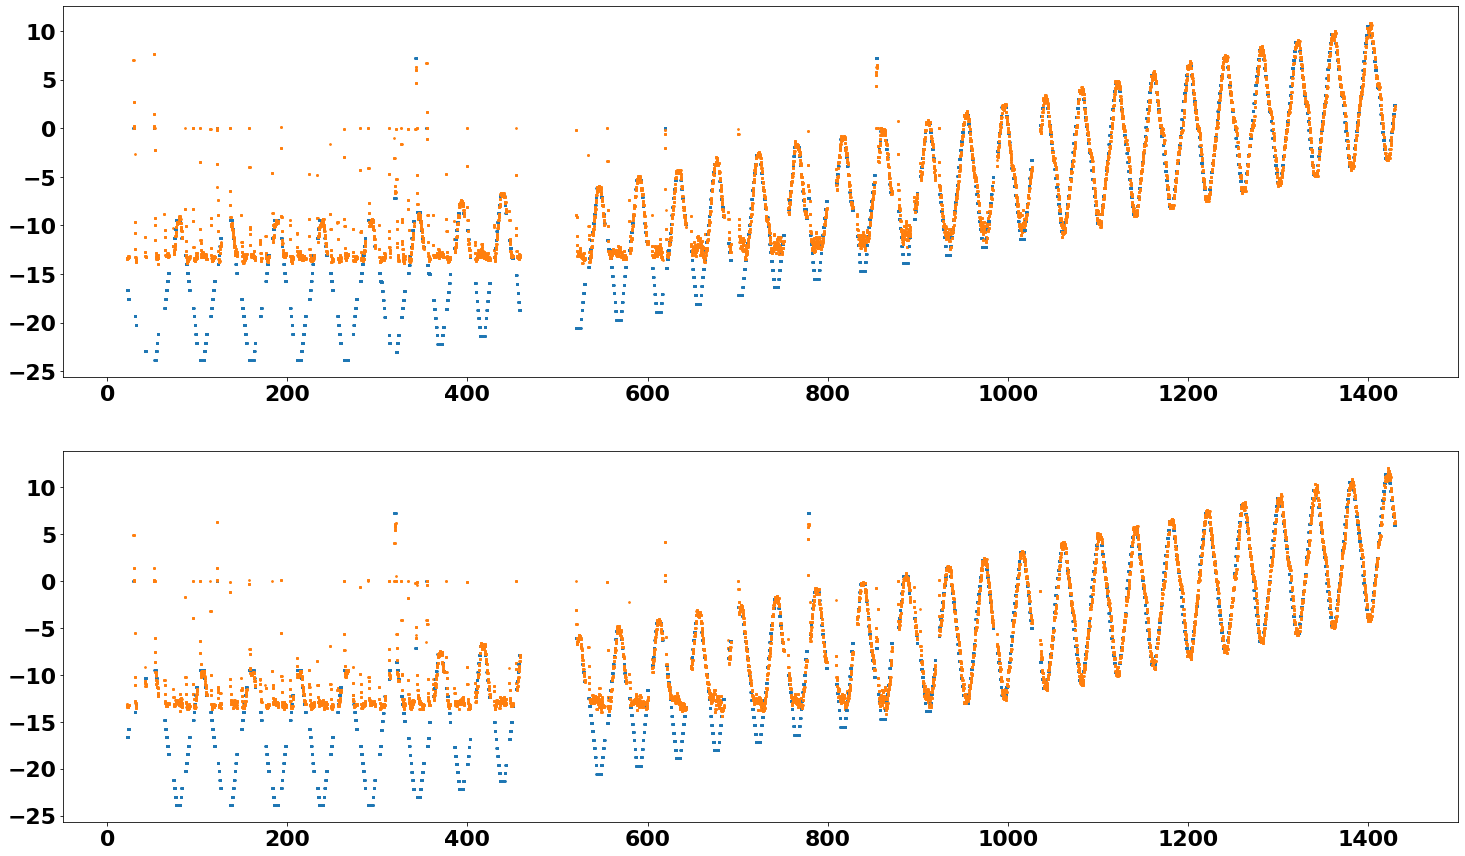

In [22]:
# plot random step
fig, (ax1, ax2) = plt.subplots(2, figsize = (25, 15))

for i in range(1, len(cmd_steps)):
    
    clear_output(wait=True)
    display(str(i) + '/' + str(len(cmd_steps)))
    time.sleep(0.001)
    
    step = cmd_steps[i]
    step_len = step[1] - step[0]
    step_linspace = np.linspace(step[0], step[1], step_len, dtype=int)
    step_timestamps = timestamp[step[0]:step[1]]
    wheel_cmds = wheels_cmd_vels[step[0]:step[1], :]
    wheel_meas = wheels_meas_vels[step[0]:step[1], :]
    ax1.scatter(step_timestamps, wheel_cmds[:, 0], c='C0', s=3)
    ax1.scatter(step_timestamps, wheel_meas[:, 0], c='C1', s=3)
    ax2.scatter(step_timestamps, wheel_cmds[:, 1], c='C0', s=3)
    ax2.scatter(step_timestamps, wheel_meas[:, 1], c='C1', s=3)

        
# step = cmd_steps[300]
# step_len = step[1] - step[0]
# step_linspace = np.linspace(step[0], step[1], step_len, dtype=int)
# wheel_cmds = wheels_cmd_vels[step[0]:step[1], :]
# plt.scatter(step_linspace, wheel_cmds[:, 0], c='C0')


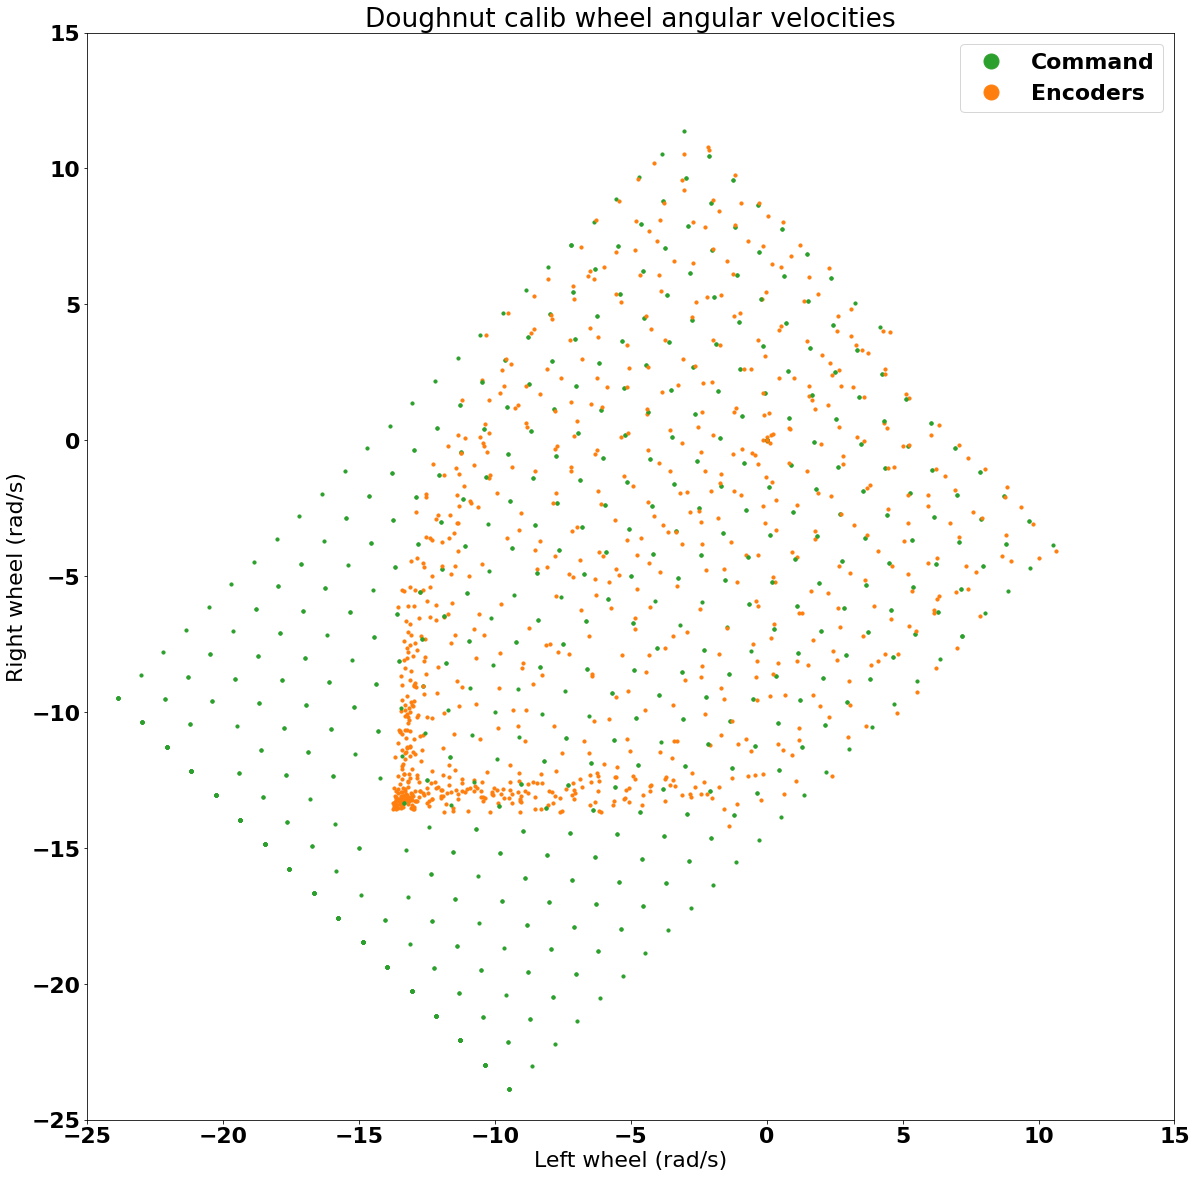

In [39]:
# compute commanded vs encoder wheel velocities

marker_size = 10

fig, ax = plt.subplots(figsize = (20, 20))

for i in range(1, len(cmd_steps)):
    
#     clear_output(wait=True)
#     display(str(i) + '/' + str(len(cmd_steps)))
#     time.sleep(0.001)
    
    step = cmd_steps[i]
    step_len = step[1] - step[0]
    step_linspace = np.linspace(step[0], step[1], step_len, dtype=int)
    step_timestamps = timestamp[step[0]:step[1]]
    wheel_cmds = wheels_cmd_vels[step[0]:step[1], :]
    wheel_meas = wheels_meas_vels[step[0]:step[1], :]
    
    ax.scatter(wheel_cmds[-1, 0], wheel_cmds[-1, 1], c='C2', s=marker_size)
    ax.scatter(wheel_meas[-1, 0], wheel_meas[-1, 1], c='C1', s=marker_size)
    

ax.set_title('Doughnut calib wheel angular velocities')
ax.set_ylabel('Right wheel (rad/s)')
ax.set_xlabel('Left wheel (rad/s)')
# ax.axis('equal')
xmin = ymin = -25
xmax = ymax = 15
ax.axis([xmin, xmax, ymin, ymax])
ax.set_aspect('equal', adjustable='box')

legend_elements = [Line2D([0], [0], marker='o', linestyle='', color='C2', label='Command', markersize=15),
                   Line2D([0], [0], marker='o', linestyle='', color='C1', label='Encoders', markersize=15)]
leg = ax.legend(handles=legend_elements, loc='best')
leg.set_alpha(1)

plt.show()

fig.savefig('figs/dougnhut_calib_wheel_vels.png')

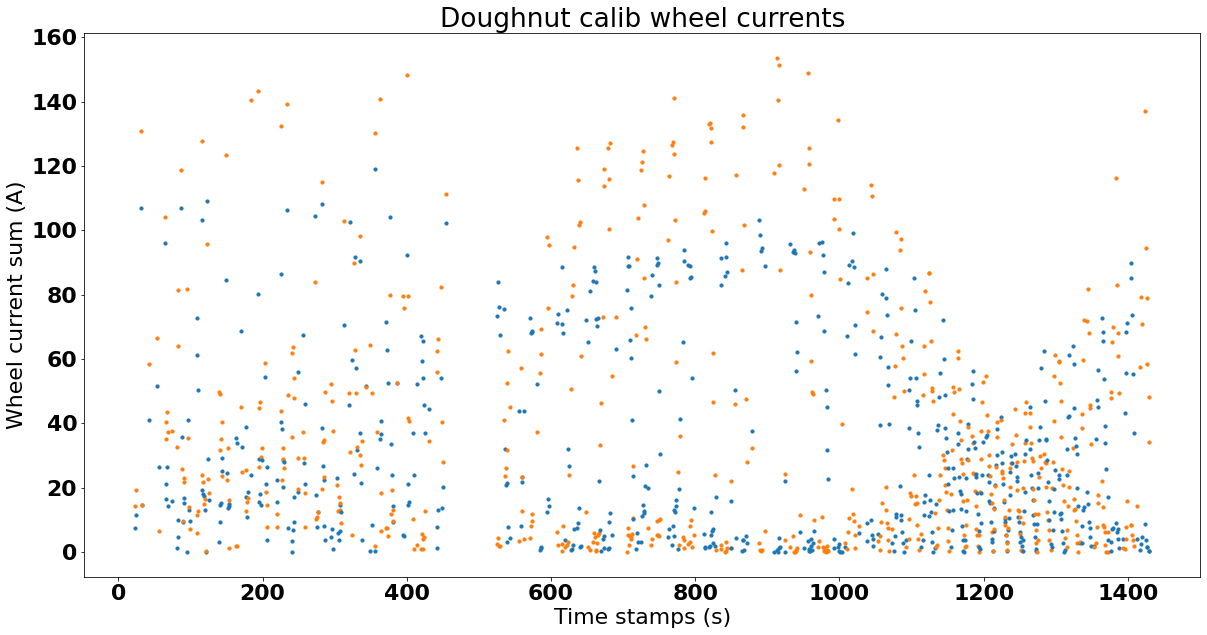

In [57]:
# Plot combined motor current to check if there is a saturation

fig, ax = plt.subplots(figsize = (20, 10))

for i in range(1, len(cmd_steps)):
    
#     clear_output(wait=True)
#     display(str(i) + '/' + str(len(cmd_steps)))
#     time.sleep(0.001)
    
    step = cmd_steps[i]
    step_len = step[1] - step[0]
    step_linspace = np.linspace(step[0], step[1], step_len, dtype=int)
    step_timestamps = timestamp[step[0]:step[1]]
    
    if wheel_currents[step[1]][0] <= 1000 and wheel_currents[step[1]][1] <= 1000:
        ax.scatter(timestamp[step[1]], wheel_currents[step[1], 0], c='C0', s=marker_size)
        ax.scatter(timestamp[step[1]], wheel_currents[step[1], 1], c='C1', s=marker_size)
#     ax.scatter(timestamp[step[1]], np.sum(wheel_currents[step[1], :]), c='C2', s=marker_size)

ax.set_title('Doughnut calib wheel currents')
ax.set_ylabel('Wheel current sum (A)')
ax.set_xlabel('Time stamps (s)')
# ax.axis('equal')
# xmin = ymin = -25
# xmax = ymax = 15
# ax.axis([xmin, xmax, ymin, ymax])
# ax.set_aspect('equal', adjustable='box')


plt.show()

fig.savefig('figs/dougnhut_calib_wheel_currents.jpg')

In [ ]:
# compute commanded vs encoder vs icp body velocities

marker_size = 10

fig, ax = plt.subplots(figsize = (20, 20))

for i in range(1, len(cmd_steps)):
    
#     clear_output(wait=True)
#     display(str(i) + '/' + str(len(cmd_steps)))
#     time.sleep(0.001)
    
    step = cmd_steps[i]
    step_len = step[1] - step[0]
    step_linspace = np.linspace(step[0], step[1], step_len, dtype=int)
    step_timestamps = timestamp[step[0]:step[1]]
    wheel_cmds = wheels_cmd_vels[step[0]:step[1], :]
    wheel_meas = wheels_meas_vels[step[0]:step[1], :]
    
    ax.scatter(wheel_cmds[-1, 0], wheel_cmds[-1, 1], c='C2', s=marker_size)
    ax.scatter(wheel_meas[-1, 0], wheel_meas[-1, 1], c='C1', s=marker_size)


plt.show()

fig.savefig('figs/dougnhut_calib_wheel_vels.png')

In [32]:
# compute cmd, meas and icp_velocities

r = 0.36
B = 1.296
k = np.array([r, B])

index_vels = np.zeros((int(icp_states[-1, 1]), 1))
cmd_vels = np.zeros((int(icp_states[-1, 1]), 3))
meas_vels = np.zeros((int(icp_states[-1, 1]), 3))
pwrtrn_vels = np.zeros((int(icp_states[-1, 1]), 3))
icp_vels = np.zeros((int(icp_states[-1, 1]), 3))

vel_count = 0
dt = 0.0
vemeasount = 0
cmd_vel_i = np.zeros((1, 3))
meas_vel_i = np.zeros((1, 3))
pwrtrn_vel_i = np.zeros((1, 3))
icp_disp = np.zeros((1, 3))
icp_trav = 0

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])

for i in range(icp_states.shape[0] - 1):
    vel_count = vel_count + 1
    cmd_vel_i = cmd_vel_i + diff_drive(wheel_vels_cmd[i, 2:], k)
    meas_vel_i = meas_vel_i + diff_drive(wheel_vels_meas[i, 2:], k)
#     pwrtrn_vel_i = pwrtrn_vel_i + diff_drive(wheel_vels_pwrtrn[i, 2:], k)
    
    dt = dt + icp_states[i+1, 0] - icp_states[i, 0]
    
    icp_trav = icp_trav + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
    
    if icp_states[i+1, 1] != icp_states[i, 1]:
        # filter out icp jumps caused by controller input
        if icp_states[i+1, 0] - icp_states[i, 0] >= 0.5:
            cmd_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            meas_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            pwrtrn_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            icp_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            dt = 0
            vel_count = 0
            cmd_vel_i = np.zeros((1, 3))
            meas_vel_i = np.zeros((1, 3))
            pwr_vel_i = np.zeros((1, 3))
            icp_disp = np.zeros((1, 3))
            icp_trav = 0
    
        else:
            index_vels[int(icp_states[i, 1])] = icp_states[i+1, 0]
            cmd_vels[int(icp_states[i, 1]), :] = cmd_vel_i / vel_count
            meas_vels[int(icp_states[i, 1]), :] = meas_vel_i / vel_count
            pwrtrn_vels[int(icp_states[i, 1]), :] = pwrtrn_vel_i / vel_count
            icp_disp = icp_disp + icp_states[i+1, 2:] - icp_states[i, 2:]
            icp_disp[0,2] = wrap2pi(icp_disp[0,2])

            propa_cos = np.cos(icp_states[i+1,4])
            propa_sin = np.sin(icp_states[i+1,4])
            propa_mat[0,0] = propa_cos
            propa_mat[0,1] = propa_sin
            propa_mat[1,0] = -propa_sin
            propa_mat[1,1] = propa_cos

            icp_disp = propa_mat @ icp_disp.flatten()

            icp_vels[int(icp_states[i, 1]), :] = icp_disp / dt

            dt = 0
            vel_count = 0
            cmd_vel_i = np.zeros((1, 3))
            meas_vel_i = np.zeros((1, 3))
#             pwrtrn_vel_i = np.zeros((1, 3))
            icp_disp = np.zeros((1, 3))
            icp_trav = 0
        
cmd_meas_err = cmd_vels - meas_vels
cmd_err = np.linalg.norm(cmd_meas_err, axis=1)
meas_icp_err = meas_vels - icp_vels
icp_err = np.linalg.norm(meas_icp_err, axis=1)
icp_err = np.clip(icp_err, 0.0, 4.0)


NameError: name 'wheel_vels_cmd' is not defined